In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from pathlib import Path

import motorlab as ml
import numpy as np

In [3]:
os.chdir(Path().resolve().parent)

In [4]:
OLD_GBYK = True
PREFIX = "old_" if OLD_GBYK else ""
EXPERIMENT_NAME = f"{PREFIX}gbyk"
SESSIONS = ml.sessions.get(EXPERIMENT_NAME)
DATA_DIR = Path("data") / EXPERIMENT_NAME
SAMPLING_RATE = 20

In [5]:
for session in SESSIONS:
    print(f"processing session {session}.")
    session_dir = DATA_DIR / session
    session_dir.mkdir(parents=True, exist_ok=True)
    # ml.gbyk.export_poses(session_dir, denoised_format=OLD_GBYK)
    # ml.gbyk.export_spikes(session_dir, spike_count_sampling_rate=20)
    # ml.gbyk.export_intervals(
    #     session_dir, homing_threshold=60000, include_homing=not OLD_GBYK
    # )
    # ml.gbyk.export_target(session_dir)
    ml.gbyk.export_pcs(session_dir, modality="poses", coordinates="egocentric")

processing session bex_20230623_denoised.
processing session ken_20230614_denoised.
processing session ken_20230618_denoised.


sanity check where i visualize one raw pose.

/Users/caio/dev/motorlab/motorlab/poses.py:30: RuntimeWarning: Mean of empty slice
  poses_data = np.nanmean(poses_data, axis=1)


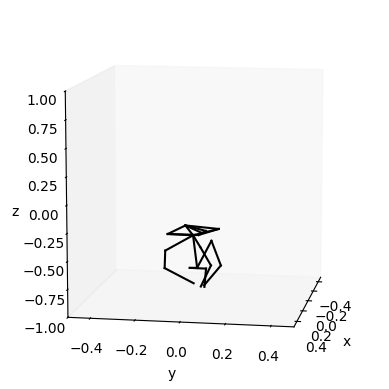

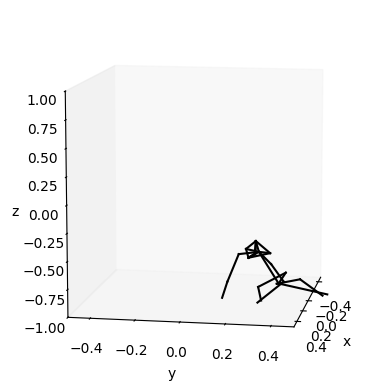

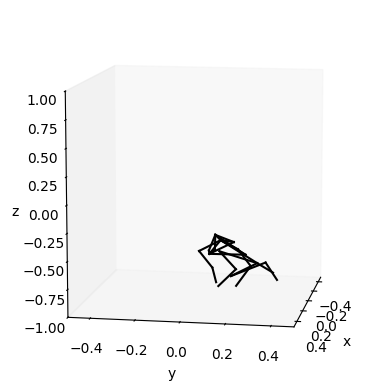

In [6]:
for session in SESSIONS:
    poses_data = ml.poses.load(DATA_DIR / session, SAMPLING_RATE)
    not_nan = np.where(~np.isnan(poses_data), True, False)
    ml.plots.poses3d(poses_data[not_nan], EXPERIMENT_NAME)

sanity check where i check if the center of mass that i saved as metadata matches the center of mass computed "by hand".

In [7]:
com_keypoints = [
    "r_shoulder",
    "r_hip",
    "l_shoulder",
    "l_hip",
    "neck",
    "s_tail",
]
com_keypoints_indices = [
    ml.keypoints.to_idx(kp, EXPERIMENT_NAME) for kp in com_keypoints
]

for session in SESSIONS:
    poses_data = ml.poses.load(DATA_DIR / session, SAMPLING_RATE)
    com_data = ml.poses.load_com(DATA_DIR / session, SAMPLING_RATE)
    poses_data = poses_data.reshape(-1, 21, 3)
    com_from_poses = poses_data[:, com_keypoints_indices, :].mean(axis=1)
    com_from_poses = np.nan_to_num(com_from_poses, nan=0.0)
    com_data = np.nan_to_num(com_data, nan=0.0)
    print(np.linalg.norm(com_from_poses - com_data) / len(poses_data))

/Users/caio/dev/motorlab/motorlab/poses.py:54: RuntimeWarning: Mean of empty slice
  com_data = np.nanmean(com_data, axis=1)


4.8198115e-05
8.113663e-05
5.868627e-05


sanity check to see if the spikes and spike count are equivalent when i use the same sampling rate for both.

In [8]:
for session in SESSIONS:
    spikes_data = ml.spikes.load(
        DATA_DIR / session, "spikes", sampling_rate=SAMPLING_RATE
    )
    spike_count_data = ml.spikes.load(
        DATA_DIR / session, "spike_count", sampling_rate=SAMPLING_RATE
    )
    print(np.allclose(spikes_data, spike_count_data))

True


KeyboardInterrupt: 

sanity check that all values are non-negative.

In [ ]:
for session in SESSIONS:
    spike_count_data = ml.spikes.load(
        DATA_DIR / session, "spike_count", sampling_rate=SAMPLING_RATE
    )
    print(np.all(spike_count_data >= 0))

just check the raw intervals data to see if i spot anything obviously wrong.

In [ ]:
session_dir = DATA_DIR / SESSIONS[0]
ml.intervals.load_as_df(session_dir, sampling_rate=SAMPLING_RATE)

,choice,start,reward,type,end,cue,tier,duration
0,L,274.0,R,precue,454.0,1.374066e+04,train,180.0
1,R,1205.0,L,precue,1449.0,6.026006e+04,train,244.0
2,L,2288.0,R,precue,2500.0,1.144209e+05,train,212.0
3,R,3300.0,R,precue,3545.0,1.650290e+05,train,245.0
4,L,4434.0,L,precue,4628.0,2.217312e+05,validation,194.0
...,...,...,...,...,...,...,...,...
68,L,154373.0,L,precue,154557.0,7.718681e+06,train,184.0
69,R,155266.0,R,precue,155464.0,7.763320e+06,test,198.0
70,L,156318.0,L,precue,156503.0,7.815932e+06,validation,185.0
71,L,157391.0,L,precue,157578.0,7.869555e+06,train,187.0


checking if the load with query works

In [ ]:
query = {"type": "precue", "tier": "train", "choice": "L"}
intervals = ml.intervals.load(session_dir, query, SAMPLING_RATE)
len(intervals)

22